In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arkadia
import datetime as dtm
from dateutil.parser import parse
from datetime import date
from datetime import datetime, timedelta
from workalendar.europe import Germany
%matplotlib inline


ModuleNotFoundError: No module named 'arkadia'

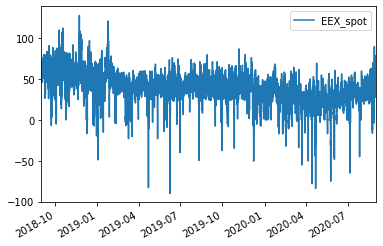

In [2]:
#Getting EEX power spot prices from Mesap
price_ref = 'EEX' 
MesapID = '1'
Hypothesis = 'REF'
date_start = parse('2018-09-01T00+02:00')
date_end = parse('2020-09-01T00+02:00')
spot_prices = arkadia.read_market_data([(MesapID, Hypothesis)],
                                                 start=date_start,
                                                 end=date_end,
                                                 output_resolution='T1H')

spot_prices.rename(columns={'1.REF': 'EEX_spot'}, inplace=True)
spot_prices.plot()



In [3]:
spot_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2018-09-01 00:00:00+02:00 to 2020-08-31 23:00:00+02:00
Freq: H
Data columns (total 1 columns):
EEX_spot    17544 non-null float32
dtypes: float32(1)
memory usage: 205.6 KB


In [4]:
def weekday_definition(orig_weekday_type):
    if orig_weekday_type == 0:
        return 'Monday'
    elif orig_weekday_type >=1 and orig_weekday_type <=3:
        return 'Tuesday-Thursday'
    elif orig_weekday_type == 4:
        return 'Friday'
    elif orig_weekday_type == 5:
        return 'Saturday'
    elif orig_weekday_type == 6:
        return 'Sunday'
    elif orig_weekday_type == 7:
        return 'Holiday'
    

In [5]:
#Standard calendar info to df
spot_prices['Year'] = spot_prices.index.year
spot_prices['Month'] = spot_prices.index.month
spot_prices['Hour'] = spot_prices.index.hour
spot_prices['Weekday'] = spot_prices.index.weekday


In [6]:
#Holidays
cal = Germany()

#Creating holiday list
Holidays = []
sYear = spot_prices.index[0].year
eYear = spot_prices.index[-1].year
for y in np.arange(sYear,eYear+1):
    temp = cal.holidays(y)
    Holidays = Holidays + temp    

Holidays # 2-dim list
Holidays_dates = [sl[0] for sl in Holidays] #1-dim list

#Marking holidays in spot price data frame
for T in spot_prices.index:
    
    if date(T.year,T.month,T.day) in Holidays_dates: 
        spot_prices.loc[T,'Weekday'] = 7 
    else:
        spot_prices.loc[T,'Weekday'] = spot_prices.loc[T,'Weekday']
    
Holidays



[(datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 3, 30), 'Good Friday'),
 (datetime.date(2018, 4, 2), 'Easter Monday'),
 (datetime.date(2018, 5, 1), 'Labour Day'),
 (datetime.date(2018, 5, 10), 'Ascension Thursday'),
 (datetime.date(2018, 5, 21), 'Whit Monday'),
 (datetime.date(2018, 10, 3), 'Day of German Unity'),
 (datetime.date(2018, 12, 25), 'Christmas Day'),
 (datetime.date(2018, 12, 26), 'Second Christmas Day'),
 (datetime.date(2019, 1, 1), 'New year'),
 (datetime.date(2019, 4, 19), 'Good Friday'),
 (datetime.date(2019, 4, 22), 'Easter Monday'),
 (datetime.date(2019, 5, 1), 'Labour Day'),
 (datetime.date(2019, 5, 30), 'Ascension Thursday'),
 (datetime.date(2019, 6, 10), 'Whit Monday'),
 (datetime.date(2019, 10, 3), 'Day of German Unity'),
 (datetime.date(2019, 12, 25), 'Christmas Day'),
 (datetime.date(2019, 12, 26), 'Second Christmas Day'),
 (datetime.date(2020, 1, 1), 'New year'),
 (datetime.date(2020, 4, 10), 'Good Friday'),
 (datetime.date(2020, 4, 13), 'Easter

In [7]:
def dst_labeling(sYear,eYear,spot_prices):
    
    spot_prices['DST']=np.zeros(len(spot_prices))
    
    for T in np.arange(sYear,eYear+1):
        #spot_prices.drop(spot_prices.index[1])
        marMonth = spot_prices[(spot_prices['Month']==3) & (spot_prices['Year']==T) & (spot_prices['Weekday']==6)]
        octMonth = spot_prices[(spot_prices['Month']==10) & (spot_prices['Year']==T) & (spot_prices['Weekday']==6)]

        #DST dates March
        if not(marMonth.empty):
            dstMar_end = marMonth.sort_index(ascending=False).index[0]
            dstMar_start = marMonth.sort_index(ascending=False).index[22]
            ind_mar = (spot_prices.index >= dstMar_start) & (spot_prices.index <= dstMar_end)
            spot_prices.loc[ind_mar,'DST']=1

        #DST dates October
        if not(octMonth.empty):
            dstOct_end = octMonth.sort_index(ascending=False).index[0]
            dstOct_start = octMonth.sort_index(ascending=False).index[24]
            ind_oct = (spot_prices.index >= dstOct_start) & (spot_prices.index <= dstOct_end)
            spot_prices.loc[ind_oct,'DST']=1

In [10]:
#adding DST information to the data frame by labeling all hours=1 for DST date 
sYear = spot_prices.index[0].year
eYear = spot_prices.index[-1].year
dst_labeling(sYear,eYear,spot_prices)
spot_prices['2019-03-31']

,EEX_spot,Year,Month,Hour,Weekday,DST
2019-03-31 00:00:00+01:00,40.099998,2019,3,0,6,1.0
2019-03-31 01:00:00+01:00,33.950001,2019,3,1,6,1.0
2019-03-31 03:00:00+02:00,31.950001,2019,3,3,6,1.0
2019-03-31 04:00:00+02:00,31.900000,2019,3,4,6,1.0
2019-03-31 05:00:00+02:00,30.540001,2019,3,5,6,1.0
2019-03-31 06:00:00+02:00,30.809999,2019,3,6,6,1.0
2019-03-31 07:00:00+02:00,32.009998,2019,3,7,6,1.0
2019-03-31 08:00:00+02:00,33.070000,2019,3,8,6,1.0
2019-03-31 09:00:00+02:00,32.779999,2019,3,9,6,1.0
2019-03-31 10:00:00+02:00,28.820000,2019,3,10,6,1.0


In [11]:
#removing datetime index so we can convert from 23/25 to 24/24 in data
new = spot_prices.reset_index().drop(['index'],axis=1)
new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 6 columns):
EEX_spot    17544 non-null float32
Year        17544 non-null int64
Month       17544 non-null int64
Hour        17544 non-null int64
Weekday     17544 non-null int64
DST         17544 non-null float64
dtypes: float32(1), float64(1), int64(4)
memory usage: 754.0 KB


In [12]:
def make_twentyfour(sYear, eYear, new):    
    
    for T in np.arange(sYear,eYear+1):
        #March
        ind_mar = (new['Year']==T) & (new['Month']==3) & (new['Hour']==3) & (new['DST']==1)
        row_mar = new[ind_mar].index
        if not(row_mar.empty):
            upper_df = new.loc[:row_mar[0]-1]
            new_row = new.loc[row_mar]
            new_row.loc[row_mar,'EEX_spot']=(new.loc[row_mar,'EEX_spot'].values + new.loc[row_mar-1,'EEX_spot'].values)/2
            new_row.loc[row_mar,'Hour']=2
            lower_df = new.loc[row_mar[0]:]
            f = pd.concat([upper_df, new_row, lower_df], ignore_index=True)
        else:
            f = new
            
                

        #October
        ind_oct = (f['Year']==T) & (f['Month']==10) & (f['Hour']==2) & (f['DST']==1)
        if not(f[ind_oct].index.empty):
            row_oct = f[ind_oct].index[0]
            f.drop(row_oct,inplace=True)
        
        new = f
     
    return new

In [13]:
#calculating price_df (in 24/24 format)
price_df = make_twentyfour(sYear, eYear, new)

#creating daterange in 24/24 format
first_date = date(spot_prices.index[0].year,spot_prices.index[0].month,spot_prices.index[0].day)
last_date = date(spot_prices.index[-1].year,spot_prices.index[-1].month,spot_prices.index[-1].day) + timedelta(days=1)
dateRange = pd.date_range(first_date, last_date, freq='H', closed='left')

#combining price_df with daterange to get a 24/24 dataframe 
price_df.set_index(dateRange, inplace = True)



In [14]:
#creating daytype groups and csalculating H2M ratios for each hour
price_df['Grouped_daytype'] = price_df['Weekday'].apply(weekday_definition)

month_avg = (price_df[['EEX_spot','Year','Month']].groupby(by=['Year','Month']).mean()
            .rename(columns={'EEX_spot':'Monthly_avg'}))

price_df = price_df.reset_index().merge(month_avg, on=['Year','Month']).set_index('index')
price_df['H2M_ratios'] = price_df['EEX_spot']/price_df['Monthly_avg']

In [15]:
#averaging over daytupe groups
averaged_profiles = (price_df[['H2M_ratios','Grouped_daytype','Month','Hour']]
                    .groupby(by=['Grouped_daytype','Month','Hour']).mean())




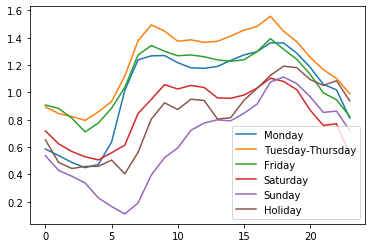

In [16]:
#Plotting average H2M weights per daytype group.
#Some nicer plotting here!! Maybe a subplot (4 x 3) where each daytype (Mon,Tues-Thur,Fri,Sat,Sun) are plotted 
#for each month.

plot_month=12

fig1 = plt.plot(averaged_profiles.loc[('Monday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Tuesday-Thursday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Friday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Saturday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Sunday',plot_month)])
fig1 = plt.plot(averaged_profiles.loc[('Holiday',plot_month)])

plt.legend(['Monday', 'Tuesday-Thursday', 'Friday', 'Saturday','Sunday','Holiday'])


In [15]:
#Onehot encoding of day types and month types Done!
#Getting temperatures + normal
#reshaping target data (=H2M-weights) to (numDays x 24) Done!!!
#Training a basic model

In [17]:
#getting historical temperature from Mesap and normal from Excel file

MesapID_Stuttgart = '29483'
temperature_station_Stuttgart = 'WMO 10738'
#Stuttgart data
temperature_Stuttgart = arkadia.read_market_data([(MesapID_Stuttgart, 'REF')], start=date_start,end=date_end, output_resolution='T1H')
temperature_daily_Stuttgart = temperature_Stuttgart.resample(rule='D').mean()
temperature_daily_Stuttgart.rename(columns={MesapID_Stuttgart +'.REF':'Temperature'},inplace=True)
temperature_daily_Stuttgart.fillna(method='bfill',inplace=True)
temperature_daily_Stuttgart = temperature_daily_Stuttgart[temperature_daily_Stuttgart.index >= date_start]

#temperature normal from Excel
temperature_normal = pd.read_excel('Normal_temperature_stuttgart.xlsx') 
temperature_normal['Date'] = pd.to_datetime(temperature_normal['Date'])
temperature_normal.set_index('Date',inplace=True) 



#merging temperature info 
daily_temp_df = pd.merge(temperature_normal, temperature_daily_Stuttgart.tz_localize(None), left_index=True, right_index=True)
daily_temp_df.head()
daily_temp_df['Temperature_dev_normal']=daily_temp_df['Temperature']-daily_temp_df['Norm_temperature']
daily_temp_df.drop(columns=['Temperature'],inplace=True)
daily_temp_df.head()


,Norm_temperature,Temperature_dev_normal
2018-09-01,17.180753,-1.609920
2018-09-02,17.053212,-2.861545
2018-09-03,16.920153,-0.811819
2018-09-04,16.781495,0.397672
2018-09-05,16.637180,2.479487


In [18]:
#onehot encoding of day types and month types
onehot_daytypes = pd.get_dummies(price_df.resample(rule='D').max()['Grouped_daytype'], prefix='Weekdays')
onehot_monthtypes = pd.get_dummies(price_df.resample(rule='D').max()['Month'], prefix='Months')
onehot_monthtypes.head()

,Months_1,Months_2,Months_3,Months_4,Months_5,Months_6,Months_7,Months_8,Months_9,Months_10,Months_11,Months_12
index,,,,,,,,,,,,
2018-09-01,0,0,0,0,0,0,0,0,1,0,0,0
2018-09-02,0,0,0,0,0,0,0,0,1,0,0,0
2018-09-03,0,0,0,0,0,0,0,0,1,0,0,0
2018-09-04,0,0,0,0,0,0,0,0,1,0,0,0
2018-09-05,0,0,0,0,0,0,0,0,1,0,0,0


In [19]:
#re-shaping H2M-ratios
nRows = int(len(price_df)/24)
reshape_h2m = np.reshape(price_df['H2M_ratios'].values,(nRows,24))
#create daily date range
daily_dateRange = pd.date_range(price_df.index[0],price_df.index[-1],freq='D')
#create data frame
col_str = ['Hour1','Hour2','Hour3','Hour4','Hour5','Hour6',
           'Hour7','Hour8','Hour9','Hour10','Hour11','Hour12',
           'Hour13','Hour14','Hour15','Hour16','Hour17','Hour18',
           'Hour19','Hour20','Hour21','Hour22','Hour23','Hour24']
daily_price_df = pd.DataFrame(data=reshape_h2m,columns=col_str,index=daily_dateRange)


In [20]:
#merging all into one df
all_data = pd.merge(pd.merge(pd.merge(daily_temp_df, onehot_daytypes, left_index=True, right_index=True),
               onehot_monthtypes,left_index=True, right_index=True),daily_price_df,left_index=True, right_index=True) 
#all_data.to_excel("data.xlsx")

# Train test split

In [22]:
#No split. All data is used for training!
y = all_data['2018-09-01':'2020-08-31'].iloc[:,20:] #Hourly shapes 
X = all_data['2018-09-01':'2020-08-31'].iloc[:,0:20] #explanatory variables 

X.tail()

,Norm_temperature,Temperature_dev_normal,Weekdays_Friday,Weekdays_Holiday,Weekdays_Monday,Weekdays_Saturday,Weekdays_Sunday,Weekdays_Tuesday-Thursday,Months_1,Months_2,Months_3,Months_4,Months_5,Months_6,Months_7,Months_8,Months_9,Months_10,Months_11,Months_12
2020-08-27,17.735895,-0.131729,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-28,17.636030,-0.686029,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-29,17.530518,-2.068018,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-30,17.419417,-3.852750,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-08-31,17.302816,-3.561149,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [24]:
model = Sequential()

model.add(Dense(20,activation='tanh'))
model.add(Dense(60,activation='tanh'))
model.add(Dense(24,activation='linear'))

model.compile(optimizer='adam',loss='mse')

In [25]:
model.fit(x=X.values,y=y.values,
          batch_size=256,epochs=1000)

Epoch 1/1000
3/3 [==============================] - 0s 0s/step - loss: 1.6795
Epoch 2/1000
3/3 [==============================] - 0s 1ms/step - loss: 1.4148
Epoch 3/1000
3/3 [==============================] - 0s 1ms/step - loss: 1.1845
Epoch 4/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.9854
Epoch 5/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.8176
Epoch 6/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.6798
Epoch 7/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.5670
Epoch 8/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.4786
Epoch 9/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.4108
Epoch 10/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.3628
Epoch 11/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.3288
Epoch 12/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3047
Epoch 13/1000
3/3 [==============================]

3/3 [==============================] - 0s 1ms/step - loss: 0.1323
Epoch 205/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1322
Epoch 206/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1324
Epoch 207/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1322
Epoch 208/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1320
Epoch 209/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1320
Epoch 210/1000
3/3 [==============================] - 0s 821us/step - loss: 0.1320
Epoch 211/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1320
Epoch 212/1000
3/3 [==============================] - 0s 850us/step - loss: 0.1317
Epoch 213/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1317
Epoch 214/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1316
Epoch 215/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 216/1000
3/3 [===================

3/3 [==============================] - 0s 1ms/step - loss: 0.1239
Epoch 407/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1240
Epoch 408/1000
3/3 [==============================] - 0s 0s/step - loss: 0.1239
Epoch 409/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 410/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1244
Epoch 411/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1238
Epoch 412/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1238
Epoch 413/1000
3/3 [==============================] - 0s 0s/step - loss: 0.1237
Epoch 414/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 415/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 416/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1235
Epoch 417/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 418/1000
3/3 [=========================

3/3 [==============================] - 0s 1ms/step - loss: 0.1165
Epoch 609/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1164
Epoch 610/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1162
Epoch 611/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1163
Epoch 612/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1164
Epoch 613/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 614/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1160
Epoch 615/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1160
Epoch 616/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1160
Epoch 617/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 618/1000
3/3 [==============================] - 0s 517us/step - loss: 0.1161
Epoch 619/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 620/1000
3/3 [=====================

3/3 [==============================] - 0s 1ms/step - loss: 0.1102
Epoch 811/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1102
Epoch 812/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1104
Epoch 813/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1102
Epoch 814/1000
3/3 [==============================] - 0s 665us/step - loss: 0.1104
Epoch 815/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1100
Epoch 816/1000
3/3 [==============================] - 0s 850us/step - loss: 0.1104
Epoch 817/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1100
Epoch 818/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1104
Epoch 819/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1101
Epoch 820/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1102
Epoch 821/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.1103
Epoch 822/1000
3/3 [===================

In [26]:
losses = pd.DataFrame(model.history.history)


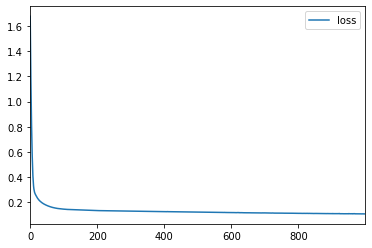

In [27]:
losses.plot()

In [28]:
predictions = model.predict(X)

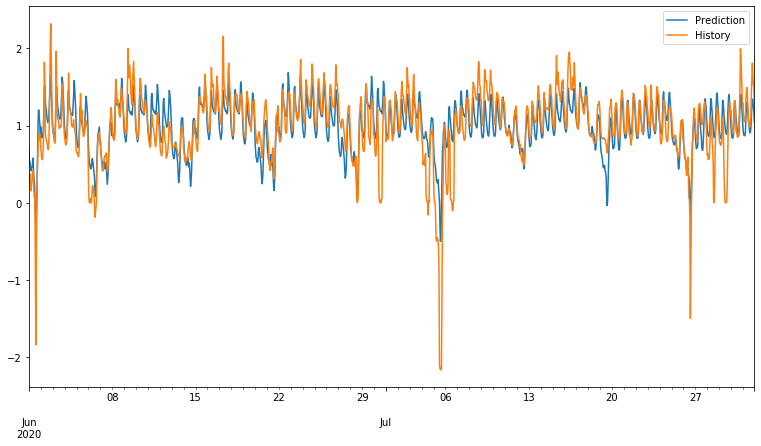

In [29]:
numObs = predictions.shape[0]*predictions.shape[1]
pred_reshape = predictions.reshape(numObs,1)
outcome = y.values.reshape(numObs,1)
pred_vs_outcome = np.concatenate((pred_reshape,outcome), axis=1)
result = pd.DataFrame(data = pred_vs_outcome, columns=['Prediction','History'], index = dateRange)
result['2020-06-01':'2020-07-31'].plot(figsize=(13,7))

In [32]:
#Making prediction based on Normal temperature (i.e. Temperatuure_dev_normal = 0)
X_pred_norm = X.copy()
X_pred_norm.loc[:,'Temperature_dev_normal']=0
predictions_norm = model.predict(X_pred_norm)

#Making prediction based on warm temperature (i.e. Temperatuure_dev_normal = 2)
X_pred_warm = X.copy()
X_pred_warm.loc[:,'Temperature_dev_normal']=2
predictions_warm = model.predict(X_pred_warm)

#Making prediction based on cold temperature (i.e. Temperatuure_dev_normal = -2)
X_pred_cold = X.copy()
X_pred_cold.loc[:,'Temperature_dev_normal']=-2
predictions_cold = model.predict(X_pred_cold)




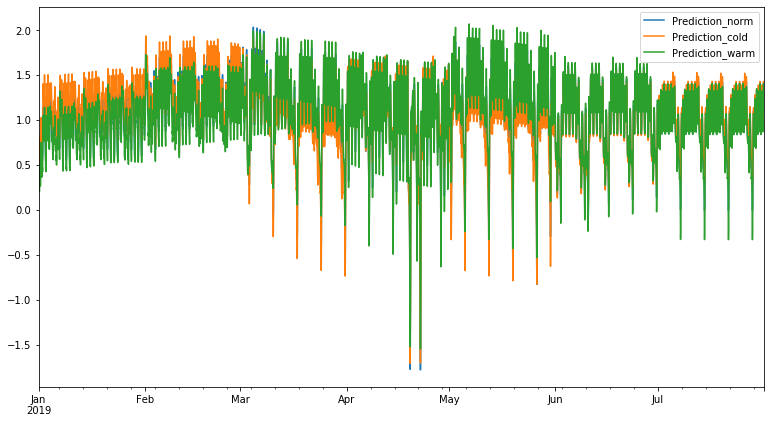

In [49]:
#Plotting predictions
numObs_norm = predictions_norm.shape[0]*predictions_norm.shape[1]
pred_norm_reshape = predictions_norm.reshape(numObs_norm,1)
pred_warm_reshape = predictions_warm.reshape(numObs_norm,1)
pred_cold_reshape = predictions_cold.reshape(numObs_norm,1)

preds = np.concatenate((pred_norm_reshape,pred_cold_reshape), axis=1)
result_preds = pd.DataFrame(data = preds, columns=['Prediction_norm','Prediction_cold'], index = dateRange)
result_preds['Prediction_warm']=pred_warm_reshape
result_preds['2019-01-01':'2019-07-31'].plot(figsize=(13,7))